In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import keras
import tensorflow as tf
import cv2
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle

Generate Data From chest_xray Folder:

In [3]:
labels = ['NORMAL', 'PNEUMONIA']  # NORMAL = 0 , PNEUMONIA = 1
all_classes_labels = ['NORMAL', 'BACTERIA', 'VIRUS']  # NORMAL = 0 , BACTERIA = 1, VIRUS = 2
IMG_SIZE = 150


#Concatenate all images in the different folders to three lists: normal, bacterial and virus

def get_training_data(data_dir):
    normal_data = []
    bacterial_data = []
    virus_data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                if label == 'NORMAL':
                  class_num = all_classes_labels.index('NORMAL')
                  normal_data.append([resized_arr, class_num])
                elif label == 'PNEUMONIA':
                  if "bacteria" in str(img):
                    class_num = all_classes_labels.index('BACTERIA')
                    bacterial_data.append([resized_arr, class_num])
                  elif "virus" in str(img):
                    class_num = all_classes_labels.index('VIRUS')
                    virus_data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(normal_data), np.array(bacterial_data), np.array(virus_data)


# Includes both normal and pneumonia cases.
normal_data, bacterial_data, virus_data = get_training_data('/content/drive/MyDrive/Deep Learning Project/chest_xray/')  # list of [image, label]


<ipython-input-3-008a6b74dcd1>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(normal_data), np.array(bacterial_data), np.array(virus_data)


Generate Train, Validation and Test Sets:

In [4]:
SEED = 42
# Separate data and labels for each class
X_normal = [data[0] for data in normal_data]
y_normal = [data[1] for data in normal_data]

X_bacterial = [data[0] for data in bacterial_data]
y_bacterial = [data[1] for data in bacterial_data]

X_virus = [data[0] for data in virus_data]
y_virus = [data[1] for data in virus_data]

# Perform train-test split for each class separately
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.15, random_state=SEED)
X_bacterial_train, X_bacterial_test, y_bacterial_train, y_bacterial_test = train_test_split(X_bacterial, y_bacterial, test_size=0.05, random_state=SEED)
X_virus_train, X_virus_test, y_virus_train, y_virus_test = train_test_split(X_virus, y_virus, test_size=0.075, random_state=SEED)

# Split the training sets into training and validation sets for each class
X_normal_train, X_normal_val, y_normal_train, y_normal_val = train_test_split(X_normal_train, y_normal_train, test_size=0.038, random_state=SEED)
X_bacterial_train, X_bacterial_val, y_bacterial_train, y_bacterial_val = train_test_split(X_bacterial_train, y_bacterial_train, test_size=0.0095, random_state=SEED)
X_virus_train, X_virus_val, y_virus_train, y_virus_val = train_test_split(X_virus_train, y_virus_train, test_size=0.019, random_state=SEED)

# Merge the data and labels for all classes
X_train = np.concatenate((X_normal_train, X_bacterial_train, X_virus_train), axis=0)
y_train = np.concatenate((y_normal_train, y_bacterial_train, y_virus_train), axis=0)
X_val = np.concatenate((X_normal_val, X_bacterial_val, X_virus_val), axis=0)
y_val = np.concatenate((y_normal_val, y_bacterial_val, y_virus_val), axis=0)
X_test = np.concatenate((X_normal_test, X_bacterial_test, X_virus_test), axis=0)
y_test = np.concatenate((y_normal_test, y_bacterial_test, y_virus_test), axis=0)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=SEED)

# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape data for deep learning
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Rest of the code for data augmentation and model training
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(X_train)


Building CNN Network:

In [5]:
def create_model():
    kernelSize = (3,3)
    poolSize = (2,2)
    strideSize = (2,2)
    # If you are creating many models in a loop, this global state will consume
    # an increasing amount of memory over time, and you may want to clear it.
    # Calling clear_session() releases the global state: this helps avoid clutter
    # from old models and layers, especially when memory is limited.
    keras.backend.clear_session()

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=kernelSize, padding='same',
                    activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))

    return model

Try Different Epochs and Learning Rates
* Compile and Train the Model for each Epoch and Learning Rate
* Plot Graphs of the Training and Validation Accuracy and Loss vs Epochs

Epoch 1/20
329/329 [==============================] - 24s 40ms/step - loss: 0.6544 - accuracy: 0.7339 - val_loss: 2.0001 - val_accuracy: 0.2476 - lr: 5.0000e-04
Epoch 2/20
329/329 [==============================] - 12s 35ms/step - loss: 0.5141 - accuracy: 0.7822 - val_loss: 0.4352 - val_accuracy: 0.8476 - lr: 5.0000e-04
Epoch 3/20
329/329 [==============================] - 12s 35ms/step - loss: 0.4765 - accuracy: 0.7976 - val_loss: 0.6119 - val_accuracy: 0.7524 - lr: 5.0000e-04
Epoch 4/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4456 - accuracy: 0.8075 - val_loss: 0.5318 - val_accuracy: 0.7810 - lr: 5.0000e-04
Epoch 5/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4110 - accuracy: 0.8231 - val_loss: 0.5515 - val_accuracy: 0.8190 - lr: 5.0000e-04
Epoch 6/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4026 - accuracy: 0.8303 - val_loss: 0.4247 - val_accuracy: 0.8476 - lr: 5.0000e-04
Epoch 7/20
329/329 [==============

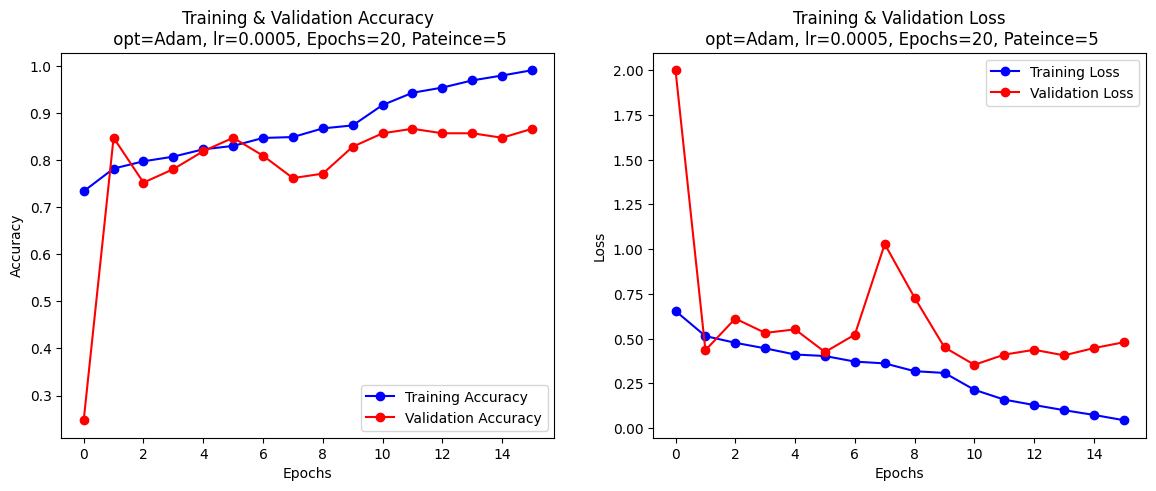

Epoch 1/20
329/329 [==============================] - 13s 37ms/step - loss: 0.6550 - accuracy: 0.7330 - val_loss: 4.2651 - val_accuracy: 0.2476 - lr: 5.0000e-04
Epoch 2/20
329/329 [==============================] - 12s 36ms/step - loss: 0.5148 - accuracy: 0.7796 - val_loss: 1.0355 - val_accuracy: 0.6286 - lr: 5.0000e-04
Epoch 3/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4743 - accuracy: 0.8012 - val_loss: 0.4143 - val_accuracy: 0.8476 - lr: 5.0000e-04
Epoch 4/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4398 - accuracy: 0.8120 - val_loss: 0.4825 - val_accuracy: 0.8095 - lr: 5.0000e-04
Epoch 5/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4177 - accuracy: 0.8254 - val_loss: 0.5177 - val_accuracy: 0.8000 - lr: 5.0000e-04
Epoch 6/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4037 - accuracy: 0.8292 - val_loss: 0.5034 - val_accuracy: 0.8476 - lr: 5.0000e-04
Epoch 7/20
329/329 [==============

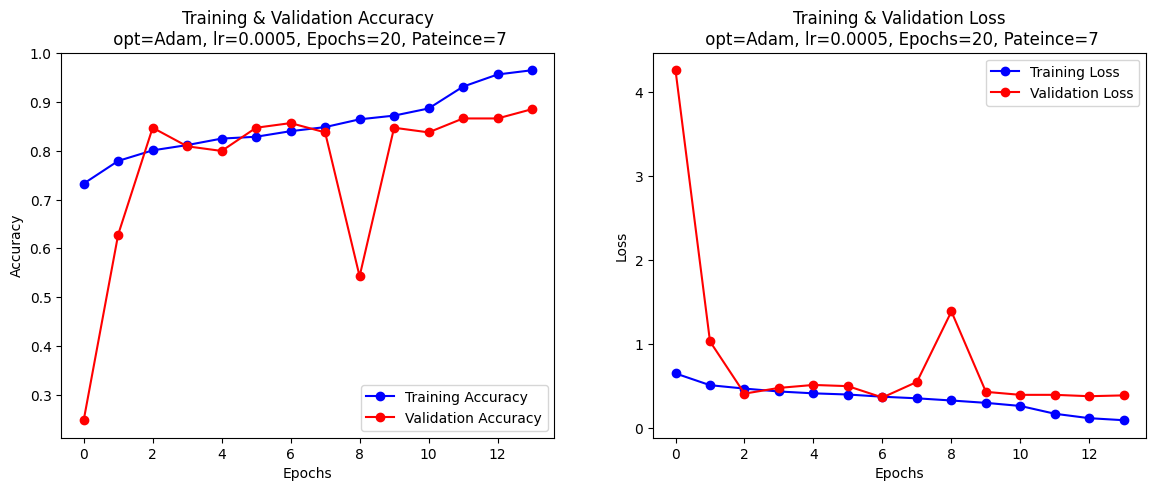

Epoch 1/20
329/329 [==============================] - 13s 37ms/step - loss: 0.6696 - accuracy: 0.7330 - val_loss: 2.4308 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 2/20
329/329 [==============================] - 12s 37ms/step - loss: 0.5181 - accuracy: 0.7822 - val_loss: 0.5923 - val_accuracy: 0.7810 - lr: 5.0000e-04
Epoch 3/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4787 - accuracy: 0.7949 - val_loss: 0.5059 - val_accuracy: 0.8286 - lr: 5.0000e-04
Epoch 4/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4521 - accuracy: 0.8063 - val_loss: 0.4558 - val_accuracy: 0.8190 - lr: 5.0000e-04
Epoch 5/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4272 - accuracy: 0.8172 - val_loss: 0.5938 - val_accuracy: 0.8000 - lr: 5.0000e-04
Epoch 6/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4047 - accuracy: 0.8265 - val_loss: 0.4164 - val_accuracy: 0.8286 - lr: 5.0000e-04
Epoch 7/20
329/329 [==============

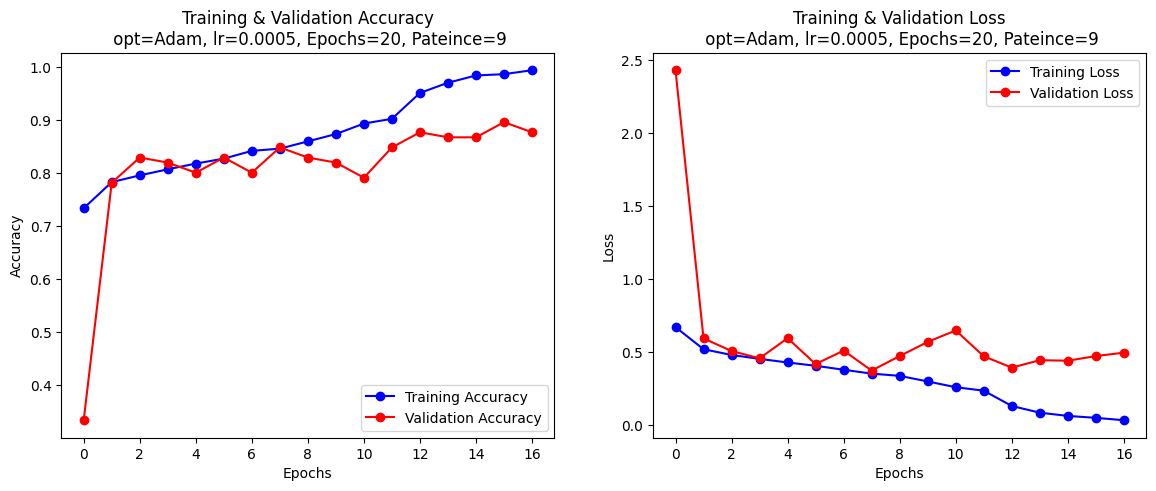

Epoch 1/20
329/329 [==============================] - 13s 37ms/step - loss: 0.6810 - accuracy: 0.7197 - val_loss: 4.3520 - val_accuracy: 0.2476 - lr: 5.0000e-04
Epoch 2/20
329/329 [==============================] - 12s 36ms/step - loss: 0.5013 - accuracy: 0.7900 - val_loss: 0.9593 - val_accuracy: 0.7143 - lr: 5.0000e-04
Epoch 3/20
329/329 [==============================] - 12s 36ms/step - loss: 0.4656 - accuracy: 0.8031 - val_loss: 0.5095 - val_accuracy: 0.7810 - lr: 5.0000e-04
Epoch 4/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4454 - accuracy: 0.8147 - val_loss: 0.4495 - val_accuracy: 0.8190 - lr: 5.0000e-04
Epoch 5/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4341 - accuracy: 0.8126 - val_loss: 0.6470 - val_accuracy: 0.7810 - lr: 5.0000e-04
Epoch 6/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4086 - accuracy: 0.8274 - val_loss: 0.4090 - val_accuracy: 0.8286 - lr: 5.0000e-04
Epoch 7/20
329/329 [==============

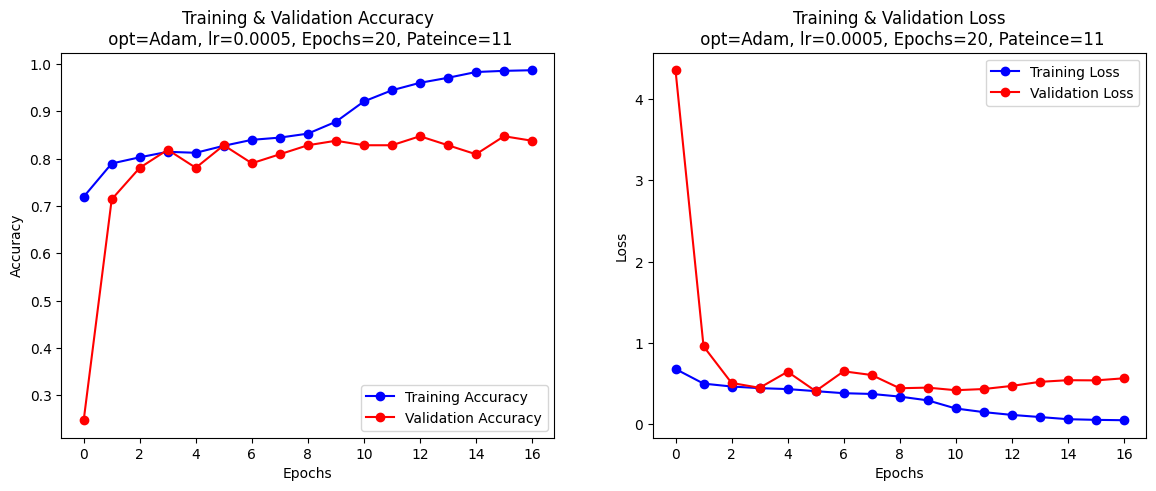

In [6]:
Epochs = 20
lr= 0.0005
Patiences = [5, 7, 9, 11]

opt = Adam

for Patience in Patiences:
    model = create_model()
    model.compile(optimizer=opt(learning_rate=lr),
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(
            monitor='val_loss',
            patience=Patience,
            min_delta=1e-7,
            restore_best_weights=False,
        )

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4,
                                            verbose=1, factor=0.2, min_lr=0.00000001)

    history = model.fit(X_train, y_train,
                        batch_size=16,
                        epochs=Epochs,
                        callbacks=[learning_rate_reduction, early_stop],
                        validation_data=(X_val, y_val))


    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    # Create a figure and subplot
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot the training and validation accuracy
    axs[0].plot(train_acc, 'bo-', label='Training Accuracy')
    axs[0].plot(val_acc, 'ro-', label='Validation Accuracy')
    axs[0].set_title(f'Training & Validation Accuracy\n opt={opt.__name__}, lr={lr}, Epochs={Epochs}, Pateince={Patience}')
    # axs[0].title.set_size(10) # if title is too big, change the size here
    axs[0].legend(loc='lower right')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")

    # Plot the training and validation loss
    axs[1].plot(train_loss, 'bo-', label='Training Loss')
    axs[1].plot(val_loss, 'ro-', label='Validation Loss')
    axs[1].set_title(f'Training & Validation Loss\n opt={opt.__name__}, lr={lr}, Epochs={Epochs}, Pateince={Patience}')
    # axs[1].title.set_size(10) # if title is too big, change the size here
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.2)

    plt.show()
